# mlrose_hiive Generator and Neural Network Runner Usage Examples - Andrew Rollings

## Overview

These examples will not solve assignment 2 for you, but they will give you
some idea on how to use the problem generator and runner classes.

Hopefully this will result in slightly fewer
"How do I &lt;insert basic usage here&gt;?" questions every semester...

Also, and in case it hasn't been made clear enough by the TAs, using any of the visualization code in here for your
assignment is a bad idea, for two reasons... (1) It provides nothing useful as far as the assignment goes,
and (2) the TAs will undoubtedly frown upon it.

Visualization is part of the analysis and, for the most part, you're supposed to do that by yourself. Just including
images of the before/after state of a problem really isn't useful in terms of what you're supposed to be analyzing.

I also strongly recommend against using the synthetic data class used within for your assignment. It's a toy, with no real
value for the assignment. There's much better data out there.

### Import Libraries

In [1]:
from IPython.core.display import display, HTML # for some notebook formatting.

import mlrose_hiive
import numpy as np
import pandas as pd
import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import SyntheticData, plot_synthetic_dataset
from mlrose_hiive import SKMLPRunner, SARunner, GARunner, NNGSRunner

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

### Generating sample data...

This sample data will be used in subsequent examples.

Features: ['(1) A', '(2) B']
Classes: ['RED', 'BLUE']


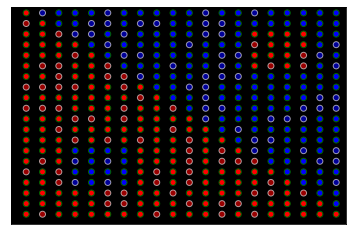

In [2]:
sd = SyntheticData(seed=123456)

clean_data, clean_features, clean_classes, _ = sd.get_synthetic_data(x_dim=20, y_dim=20)

print(f'Features: {clean_features}')
print(f'Classes: {clean_classes}')

cx, cy, cx_tr, cx_ts, cy_tr, cy_ts = sd.setup_synthetic_data_test_train(clean_data)
plot_synthetic_dataset(x_train=cx_tr, y_train=cy_tr, x_test=cx_ts, y_test=cy_ts, transparent_bg=False, bg_color='black')

This is our standard 20x20 sample set with no noise or errors, with a 70/30 split between training and test data.

Each point represents a data sample.
Black-outlined points represent training data, and white-outlined points represent test data.

A sample of the clean data can be seen below, with the first two columns being the (x,y) position of the data point, and the third
column representing the color.

In [3]:
HTML(pd.DataFrame(columns=['x', 'y', 'c'], data=clean_data)[150:160].to_html())

,x,y,c
150,7,10,0
151,7,11,0
152,7,12,0
153,7,13,1
154,7,14,1
155,7,15,1
156,7,16,1
157,7,17,1
158,7,18,1
159,7,19,1


We can generate "dirty" data in two ways: by adding an column of random data,
or by introducing noisy duplicate data points that either reinforce or contradict
existing data points.

Features: ['(1) A', '(2) B']
Classes: ['RED', 'BLUE']


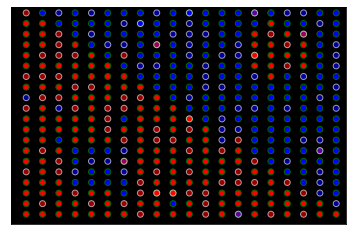

In [4]:
noisy_data, noisy_features, noisy_classes, _ = sd.get_synthetic_data(x_dim=20, y_dim=20, add_noise=0.025)
print(f'Features: {noisy_features}')
print(f'Classes: {noisy_classes}')

nx, ny, nx_tr, nx_ts, ny_tr, ny_ts = sd.setup_synthetic_data_test_train(noisy_data)
plot_synthetic_dataset(x_train=nx_tr, y_train=ny_tr, x_test=nx_ts, y_test=ny_ts, transparent_bg=False, bg_color='black')

This is our data with 2.5% added noise.
A sample of the noisy data can be seen below, with the first two columns being the (x,y) position of the data point, and the third
column representing the color. Note that the sample shown represent some of the noisy data,
which is added to the end of the clean data.

In [5]:
HTML(pd.DataFrame(columns=['x', 'y', 'c'], data=noisy_data)[-10:].to_html())

,x,y,c
410,17,17,1
411,15,18,0
412,15,19,0
413,0,6,0
414,10,14,1
415,7,8,1
416,10,19,1
417,10,9,0
418,16,1,0
419,6,0,1


If we had chosen to add the random column of data, then the plots
would look that same as the above two, depending on whether we had
chosen to additionally add noise or not.

However, the features are different, as shown below, and we can see the extra
column in the data sample.

In [6]:
extra_data, extra_features, extra_classes, _ = sd.get_synthetic_data(x_dim=20, y_dim=20, add_redundant_column=True)
print(f'Features: {extra_features}')
print(f'Classes: {extra_classes}')

ex, ey, ex_tr, ex_ts, ey_tr, ey_ts = sd.setup_synthetic_data_test_train(extra_data)

Features: ['(1) A', '(2) B', '(3) R']
Classes: ['RED', 'BLUE']


In [7]:
HTML(pd.DataFrame(columns=['x', 'y', 'r', 'c'], data=extra_data)[150:160].to_html())

,x,y,r,c
150,7.0,10.0,0.972641,0.0
151,7.0,11.0,0.726259,0.0
152,7.0,12.0,0.412651,0.0
153,7.0,13.0,0.990003,1.0
154,7.0,14.0,0.535660,1.0
155,7.0,15.0,0.559253,1.0
156,7.0,16.0,0.867020,1.0
157,7.0,17.0,0.019276,1.0
158,7.0,18.0,0.123097,1.0
159,7.0,19.0,0.808300,1.0


### Preparing the experiment parameters

In [8]:
# ensure defaults are in grid search
default_grid_search_parameters = {
    'max_iters': [5000],
    'learning_rate_init': [0.1, 0.2, 0.4, 0.8],
    'hidden_layer_sizes': [[4, 4, 4]],
    'activation': [mlrose_hiive.neural.activation.relu],
}

default_parameters = {
    'seed': 123456,
    'iteration_list': 2 ** np.arange(13),
    'max_attempts': 5000,
    'override_ctrl_c_handler': False, # required for running in notebook
    'n_jobs':5,
    'cv':5,
}

### Example 1: Running the SKMLPRunner

#### (a) Clean Data

In [9]:
skmlp_grid_search_parameters = {
    **default_grid_search_parameters,
    'max_iters': [5000],
    'learning_rate_init': [0.0001],
    'activation': [mlrose_hiive.neural.activation.sigmoid],
}

skmlp_default_parameters = {
    **default_parameters,
    'early_stopping':True,
    'tol':1e-05,
    'alpha':0.001,
    'solver':'lbfgs',
}

In [10]:
cx_skr = SKMLPRunner(x_train=cx_tr, y_train=cy_tr,
                  x_test=cx_ts, y_test=cx_ts,
                  experiment_name='skmlp_clean',
                  grid_search_parameters = skmlp_grid_search_parameters,
                  **skmlp_default_parameters)

run_stats_df, curves_df, cv_results_df, cx_sr = cx_skr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.2min finished


The following plot shows the baseline predictions made for the clean dataset using the SKLearn runner.

Note that the background coloring shows the prediction made by the learner for that area.
The intensity of the color is indicative of the prediction confidence level.

Hidden layer size: [4, 4, 4]


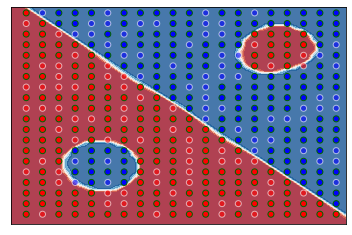

In [11]:
print(f'Hidden layer size: {cx_sr.best_params_["hidden_layer_sizes"]}')
plot_synthetic_dataset(x_train=cx_tr, y_train=cy_tr, x_test=cx_ts, y_test=cy_ts, classifier=cx_sr.best_estimator_.mlp)

#### (b) Noisy Data

In [12]:
nx1_skr = SKMLPRunner(x_train=nx_tr, y_train=ny_tr,
                  x_test=nx_ts, y_test=nx_ts,
                  experiment_name='skmlp_noisy_1',
                  grid_search_parameters = skmlp_grid_search_parameters,
                  **skmlp_default_parameters)

nx1_run_stats_df, nx1_curves_df, nx1_cv_results_df, nx1_sr = nx1_skr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.5min finished


The following plot shows the predictions made for the noisy dataset using the sklearn runner
with the same hidden layer size as the best clean set run.

Hidden layer size: [4, 4, 4]


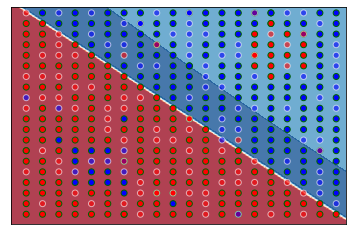

In [13]:
print(f'Hidden layer size: {nx1_sr.best_params_["hidden_layer_sizes"]}')
plot_synthetic_dataset(x_train=nx_tr, y_train=ny_tr, x_test=nx_ts, y_test=ny_ts, classifier=nx1_sr.best_estimator_.mlp)

In [14]:
noisy_data_grid_search_parameters = {
    **skmlp_grid_search_parameters,
    'hidden_layer_sizes': [[4, 4, 4, 4]],
}
nx2_skr = SKMLPRunner(x_train=nx_tr, y_train=ny_tr,
                  x_test=nx_ts, y_test=nx_ts,
                  experiment_name='skmlp_noisy_2',
                  grid_search_parameters = noisy_data_grid_search_parameters,
                  **skmlp_default_parameters)

nx2_run_stats_df, nx2_curves_df, nx2_cv_results_df, nx2_sr = nx2_skr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  2.0min remaining:  3.0min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.1min finished


The following plot shows the predictions made for the noisy dataset using the sklearn runner
with the optimal hidden layer size.

Hidden layer size: [4, 4, 4, 4]


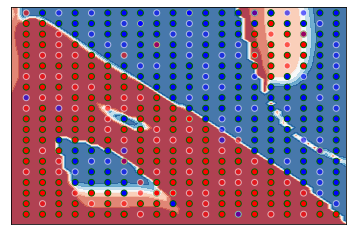

In [15]:
print(f'Hidden layer size: {nx2_sr.best_params_["hidden_layer_sizes"]}')
plot_synthetic_dataset(x_train=nx_tr, y_train=ny_tr, x_test=nx_ts, y_test=ny_ts, classifier=nx2_sr.best_estimator_.mlp)

#### (c) Extra Data

In [16]:
ex1_skr = SKMLPRunner(x_train=ex_tr, y_train=ey_tr,
                  x_test=ex_ts, y_test=ex_ts,
                  experiment_name='skmlp_extra_1',
                  grid_search_parameters = skmlp_grid_search_parameters,
                  **skmlp_default_parameters)

ex1_run_stats_df,ex1_curves_df, ex1_cv_results_df,ex1_sr = ex1_skr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.6min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  1.9min finished


The following plot shows the baseline predictions made for the extra-column dataset using the sklearn runner
with the same hidden layer size as the best clean set run:

Hidden layer size: [4, 4, 4]


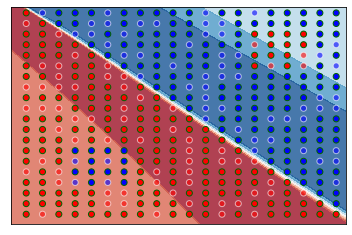

In [17]:
print(f'Hidden layer size: {ex1_sr.best_params_["hidden_layer_sizes"]}')
plot_synthetic_dataset(x_train=ex_tr, y_train=ey_tr, x_test=ex_ts, y_test=ey_ts, classifier=ex1_sr.best_estimator_.mlp)

In [18]:
# override the hidden_layer_sizes grid search.
extra_data_grid_search_parameters = {
    **skmlp_grid_search_parameters,
    'hidden_layer_sizes': [[6, 6, 6]],
}

ex2_skr = SKMLPRunner(x_train=ex_tr, y_train=ey_tr,
                  x_test=ex_ts, y_test=ex_ts,
                  experiment_name='skmlp_extra_2',
                  grid_search_parameters = extra_data_grid_search_parameters,
                  **skmlp_default_parameters)

ex2_run_stats_df, ex2_curves_df, ex2_cv_results_df, ex2_sr = ex2_skr.run()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  1.3min remaining:  1.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  2.0min finished


The following plot shows the baseline predictions made for the extra-column dataset using the sklearn runner
with the optimal hidden layer size:

Hidden layer size: [6, 6, 6]


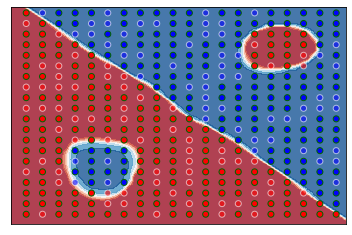

In [19]:
print(f'Hidden layer size: {ex2_sr.best_params_["hidden_layer_sizes"]}')
plot_synthetic_dataset(x_train=ex_tr, y_train=ey_tr, x_test=ex_ts, y_test=ey_ts, classifier=ex2_sr.best_estimator_.mlp)